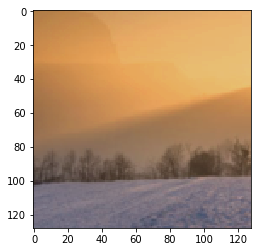

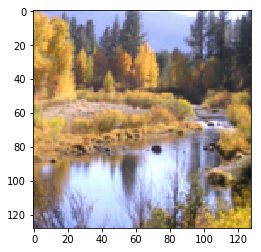

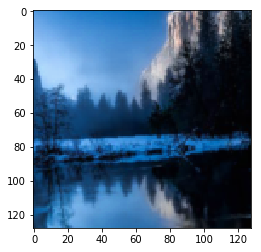

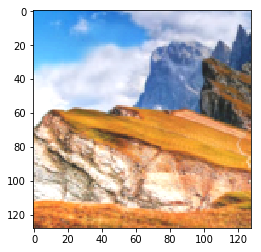

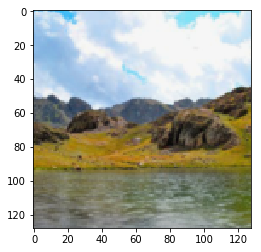

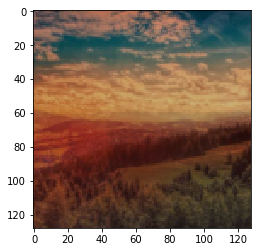

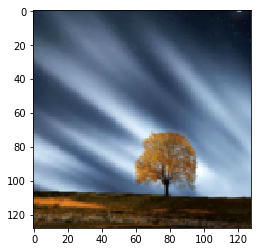

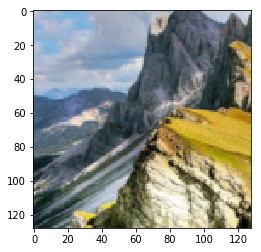

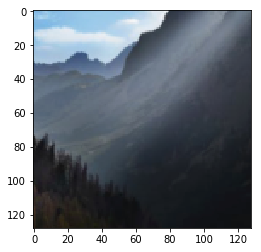

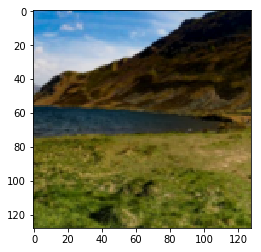

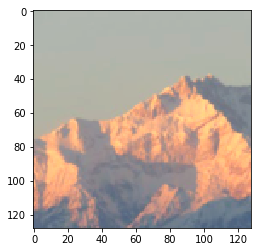

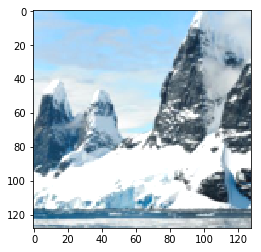

In [1]:
%matplotlib inline

import torch as th
import torchvision
import matplotlib.pyplot as plt
import Dataloader

# select the device to be used for training
device = th.device("cuda" if th.cuda.is_available() else "cpu")

transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(3),
    torchvision.transforms.RandomCrop((256, 256)), # TODO: Random scale too
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(.2, .2, .1, .01),
    torchvision.transforms.ToTensor(),
  ])

dataset = Dataloader.FlatDirectoryImageDataset('/Users/nicolas.dahlquist/datasets/pexels/landscapes', transform=transforms)

for i, d in enumerate(dataset):
    plt.imshow(d.permute(1, 2, 0).numpy())
    plt.show()
    if i > 10:
         break



In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

vgg = models.vgg13_bn(pretrained=True).to(device)

# freeze all model parameters
vgg.eval()
for param in vgg.parameters():
    param.requires_grad = False


def extract_features(x):
  # x = normalize(x)  # TODO
  #print(x.min(), x.max())
  
  # This is an approximation of the transform that the torchvision models want.
  x = (x - .5) * .6

  for i in range(12):
    x = vgg.features[i](x)
  return x

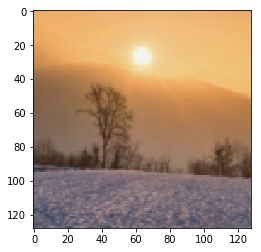

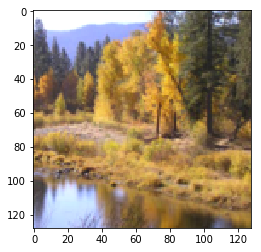

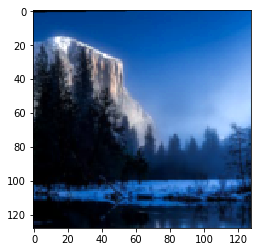

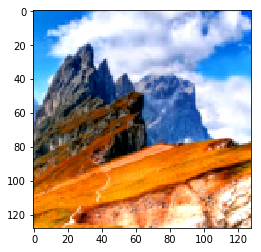

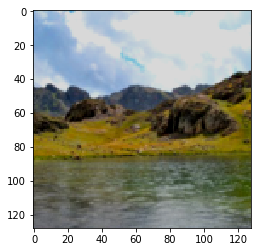

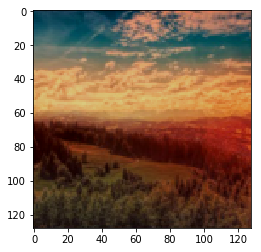

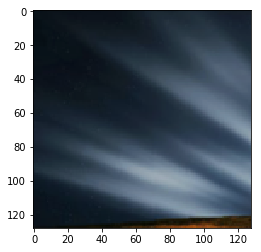

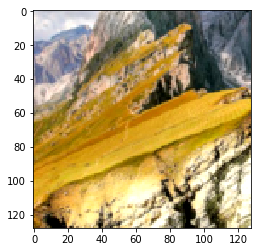

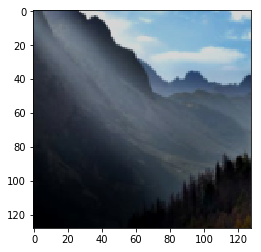

In [3]:
batch_size = 9

dataloader = torch.utils.data.DataLoader(dataset, batch_size)

target = next(iter(dataloader))
for i in range(batch_size):
    plt.imshow(target[i].permute(1, 2, 0).numpy())
    plt.show()


In [4]:
def create_grid(samples, img_file, scale_factor=1):
    """
    utility function to create a grid of GAN samples
    :param samples: generated samples for storing
    :param scale_factor: factor for upscaling the image
    :param img_file: name of file to write
    :return: None (saves a file)
    """
    from torchvision.utils import save_image
    from torch.nn.functional import interpolate

    # upsample the image
    if scale_factor > 1:
        samples = interpolate(samples, scale_factor=scale_factor)

    # save the images:
    save_image(samples, img_file, nrow=int(np.sqrt(len(samples))),
               normalize=True, scale_each=True)

In [6]:
import PRO_GAN
import torch

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2

latent_size = 128

g = PRO_GAN.Generator(depth=7, latent_size=latent_size)


latent_vector = torch.randn(batch_size, latent_size, requires_grad=True)

optimizer = torch.optim.Adam(list(g.parameters()) + [latent_vector], lr=.001)


for i in tqdm(range(1000)):
    generated = g(latent_vector, 1, 0)
    loss = torch.mean(torch.abs(target - generated))
    perceptual_loss = torch.mean(torch.abs(extract_features(target) - extract_features(generated)))
    print(latent_vector[0].detach().numpy())
    
    if i % 100 == 0:
        print(loss.detach().numpy())
        plt.imshow(generated[0].permute(1, 2, 0).detach().cpu().numpy())
        plt.show()
    create_grid(generated, 'samples/%d.png' % i)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()




  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



RuntimeError: The size of tensor a (128) must match the size of tensor b (8) at non-singleton dimension 3